In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipaddress

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Data loading

In [2]:
# Data size and partitioning
num_samples = 10000
outlier_ratio = 0.4

col_names = ['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

train_data_partition = {"background" : num_samples,
                  "blacklist" : num_samples * outlier_ratio / 2 - 40,
                  "sshscan" : num_samples * outlier_ratio / 2,
                  "spam" : None}

def load_train_dataframe(name):
    return pd.read_csv(f'data/training/{name}_flows_cut.csv', header = None, names = col_names, nrows = train_data_partition[name])

In [3]:
names = ['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

background = load_train_dataframe("background")
blacklist = load_train_dataframe("blacklist")
sshscan = load_train_dataframe("sshscan")
spam = load_train_dataframe("spam")

df = pd.concat([background, blacklist, spam, sshscan], ignore_index=True)

In [4]:
def cast_dataframe(df):
    # Convert timestamp to epoch integer
    df.end_epoch = pd.to_datetime(df.end_epoch).view(np.int64)

    # Convert attack to boolean
    df.attack = df.attack.apply(lambda x: x != 'background')

    # Convert IPs to int
    #df[["src_ip", "dst_ip"]] = df[["src_ip", "dst_ip"]].apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    df.src_ip = df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    df.dst_ip = df.dst_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))

In [5]:
cast_dataframe(df)
df.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,protocol,flags,status,service_type,packets,bytes,attack
0,1460937720000000000,55.952,719034749,3564343560,32004,55116,TCP,.A....,0,0,29544,1197024,False
1,1460937721000000000,13.148,2403862665,719035623,53,56415,UDP,.A....,0,0,2,250,False
2,1460937721000000000,13.160,2403862665,719035623,53,42993,UDP,.A....,0,0,2,256,False
3,1460937722000000000,12.704,2403862665,719035623,53,49453,UDP,.A....,0,0,2,256,False
4,1460937722000000000,13.196,2403862665,719035623,53,49998,UDP,.A....,0,0,2,256,False


In [6]:
num_samples_attacks = num_samples * outlier_ratio // 6

test_data_partition = {"background" : num_samples,
                       "blacklist" : num_samples_attacks,
                       "botnet" : num_samples_attacks,
                       "dos" : num_samples_attacks,
                       "scan11" : num_samples_attacks,
                       "scan44" : num_samples_attacks,
                       "spam" : num_samples_attacks,
                       "sshscan" : None}

def load_test_dataframe(name):
    return pd.read_csv(f'data/test/{name}_flows_cut.csv', header = None, names = col_names, nrows = test_data_partition[name])

In [7]:
background = load_test_dataframe("background")
blacklist = load_test_dataframe("blacklist")
botnet = load_test_dataframe("botnet")
dos = load_test_dataframe("dos")
scan11 = load_test_dataframe("scan11")
scan44 = load_test_dataframe("scan44")
spam = load_test_dataframe("spam")
sshscan = load_test_dataframe("sshscan")

df_test = pd.concat([background, blacklist, botnet, dos, scan11, scan44, spam, sshscan], ignore_index=True)

cast_dataframe(df_test)

df_test

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,protocol,flags,status,service_type,packets,bytes,attack
0,1470614993000000000,45.780,719036252,732179517,0,769,ICMP,.A....,0,192,11,880,False
1,1470614996000000000,44.256,719034872,1022552137,80,26289,TCP,.A..S.,0,0,3,164,False
2,1470614998000000000,50.608,719034727,3321446059,0,771,ICMP,.A....,0,200,8,832,False
3,1470615000000000000,51.968,719036246,3143438094,0,769,ICMP,.A....,0,192,31,2480,False
4,1470615001000000000,0.000,1788278962,719034713,40022,15621,UDP,.A....,0,0,1,48,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13996,1470962639000000000,0.000,549291160,719035623,22,41717,TCP,...R..,0,40,1,40,True
13997,1470967497000000000,0.000,719035623,3755633326,33171,22,TCP,...R..,0,0,1,40,True
13998,1470967498000000000,0.000,3755633326,719035623,22,33171,TCP,.A....,0,0,1,40,True
13999,1471097408000000000,0.000,3073309192,719035623,22,30173,TCP,.A.R..,0,0,1,40,True


In [8]:
print(f'Size of the dataset: {len(df)}\n')
print(f'Sumber of Nan values: {df.isnull().values.sum()}\n')
print(f'Column number: {len(df.columns)}\n')
print(f'Column names:\n{list(df.columns)}\n')
print('Column types:')
df.dtypes

Size of the dataset: 14001

Sumber of Nan values: 0

Column number: 13

Column names:
['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

Column types:


end_epoch         int64
duration        float64
src_ip            int64
dst_ip            int64
src_port          int64
dst_port          int64
protocol         object
flags            object
status            int64
service_type      int64
packets           int64
bytes             int64
attack             bool
dtype: object

#### Control of flows

In [9]:
print(f"Number of background exchanges : {len(df[df.attack == False])}")
print(f"Number of attack: {len(df[df.attack])}")
print(f"Number of blacklisted IP attack: {len(blacklist)}")
print(f"Number of ssh scan attack: {len(sshscan)}")
print(f"Number of spam attack: {len(spam)}")

Number of background exchanges : 10000
Number of attack: 4001
Number of blacklisted IP attack: 666
Number of ssh scan attack: 5
Number of spam attack: 666


#### Numeric columns

In [10]:
numeric_df = df._get_numeric_data()
numeric_df.describe()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes
count,1.400100e+04,14001.000000,1.400100e+04,1.400100e+04,14001.000000,14001.000000,14001.0,14001.000000,14001.000000,1.400100e+04
mean,1.460939e+18,1.887841,1.559093e+09,1.297139e+09,23158.166202,21919.739019,0.0,6.868867,14.949789,7.601134e+03
std,1.171379e+13,5.239898,1.085733e+09,9.642675e+08,24416.405318,24220.935655,0.0,18.425276,300.699236,1.935367e+05
min,1.460938e+18,0.000000,5.413058e+08,4.007920e+08,0.000000,0.000000,0.0,0.000000,1.000000,3.100000e+01
25%,1.460938e+18,0.000000,7.190356e+08,7.190356e+08,53.000000,53.000000,0.0,0.000000,1.000000,8.300000e+01
50%,1.460938e+18,0.092000,1.010349e+09,7.190361e+08,8080.000000,445.000000,0.0,0.000000,3.000000,3.000000e+02
75%,1.460938e+18,1.556000,2.403863e+09,1.289979e+09,48997.000000,47364.000000,0.0,0.000000,11.000000,1.320000e+03
max,1.461503e+18,194.796000,4.294738e+09,4.294738e+09,65521.000000,65521.000000,0.0,200.000000,29544.000000,1.765682e+07


## Dataset Visualisation

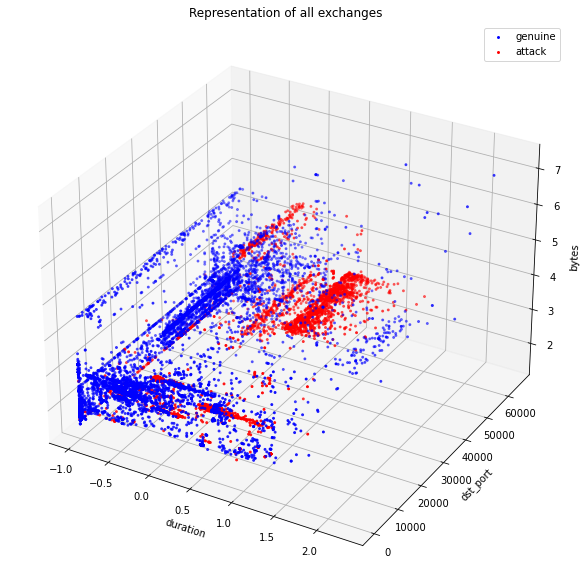

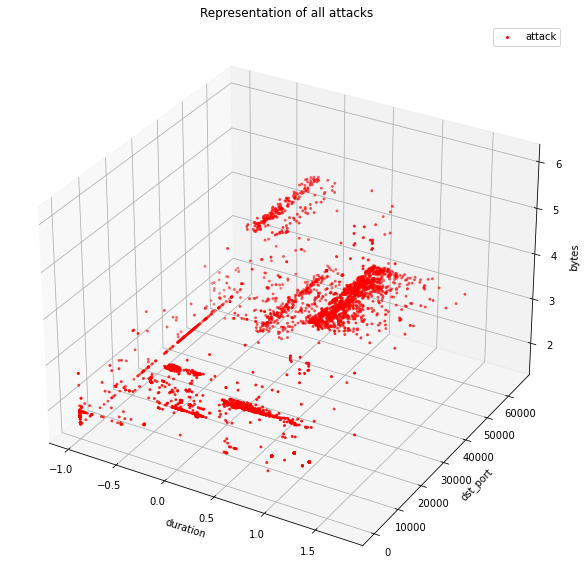

In [11]:
def show3D_flow_exchanges(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    for attack in df.attack.unique():
        df_label = df[df.attack == attack]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(np.log10(x + 0.1), y, np.log10(z), color= 'red' if attack else 'blue' , label='attack' if attack else 'genuine', marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges(df, 'duration', 'dst_port', 'bytes', 'Representation of all exchanges')
show3D_flow_exchanges(df[df.attack], 'duration', 'dst_port', 'bytes', 'Representation of all attacks')

## Data Cleaning

In [12]:
one_hot_encoded_df = pd.get_dummies(df)
display(one_hot_encoded_df.head())
print(one_hot_encoded_df.isna().sum().any())

one_hot_encoded_df_test = pd.get_dummies(df_test)
one_hot_encoded_df_test['protocol_ESP'] = 0
one_hot_encoded_df_test['protocol_GRE'] = 0
one_hot_encoded_df_test['protocol_IPv6'] = 0

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RS.,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF
0,1460937720000000000,55.952,719034749,3564343560,32004,55116,0,0,29544,1197024,...,0,0,0,0,0,0,0,0,0,0
1,1460937721000000000,13.148,2403862665,719035623,53,56415,0,0,2,250,...,0,0,0,0,0,0,0,0,0,0
2,1460937721000000000,13.160,2403862665,719035623,53,42993,0,0,2,256,...,0,0,0,0,0,0,0,0,0,0
3,1460937722000000000,12.704,2403862665,719035623,53,49453,0,0,2,256,...,0,0,0,0,0,0,0,0,0,0
4,1460937722000000000,13.196,2403862665,719035623,53,49998,0,0,2,256,...,0,0,0,0,0,0,0,0,0,0


False


## Outlier detection

#### Isolation Forests

In [13]:
classifier = IsolationForest(contamination=outlier_ratio, n_estimators=2).fit(one_hot_encoded_df.values)
y_pred = classifier.predict(one_hot_encoded_df_test.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['if_outliers'] = [i == -1 for i in  y_pred]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers
0,1460937720000000000,55.952,719034749,3564343560,32004,55116,0,0,29544,1197024,...,0,0,0,0,0,0,0,0,0,True
1,1460937721000000000,13.148,2403862665,719035623,53,56415,0,0,2,250,...,0,0,0,0,0,0,0,0,0,True
2,1460937721000000000,13.160,2403862665,719035623,53,42993,0,0,2,256,...,0,0,0,0,0,0,0,0,0,True
3,1460937722000000000,12.704,2403862665,719035623,53,49453,0,0,2,256,...,0,0,0,0,0,0,0,0,0,True
4,1460937722000000000,13.196,2403862665,719035623,53,49998,0,0,2,256,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13996,1460937764000000000,4.900,1192241069,719035623,22,55892,0,8,12,1846,...,0,0,0,0,1,0,0,0,0,False
13997,1460937764000000000,4.324,1192241114,719035623,22,37854,0,8,12,1838,...,0,0,0,0,1,0,0,0,0,True
13998,1460937751000000000,9.256,1192241097,719035623,22,41192,0,8,12,1440,...,0,0,0,1,0,0,0,0,0,True
13999,1460937764000000000,4.156,1192240917,719035623,22,33211,0,8,13,1890,...,0,0,0,0,1,0,0,0,0,True


In [14]:
def describe_precision(col):
    fraudulent_outliers = df_outliers[(df_outliers["attack"]) & (df_outliers[col])]
    print(f'{len(fraudulent_outliers)} attacks are labelled as outlier.')

    fraudulent_inliers = df_outliers[(df_outliers["attack"]) & (df_outliers[col] == False)]
    print(f'{len(fraudulent_inliers)} attacks are not labelled as outlier.')

    not_fraudulent_outliers = df_outliers[(df_outliers["attack"] == False) & (df_outliers[col])]
    print(f'{len(not_fraudulent_outliers)} genuine exchanges are labelled as outlier.')

    not_fraudulent_inliers = df_outliers[(df_outliers["attack"] == False) & (df_outliers[col] == False)]
    print(f'{len(not_fraudulent_inliers)} genuine exchanges are not labelled as outlier.')

In [15]:
describe_precision("if_outliers")

3630 attacks are labelled as outlier.
371 attacks are not labelled as outlier.
9208 genuine exchanges are labelled as outlier.
792 genuine exchanges are not labelled as outlier.


#### Local Outlier Factor

In [16]:
localOutlierFactor = LocalOutlierFactor(contamination=outlier_ratio, n_neighbors=len(df) - 1).fit(one_hot_encoded_df.values)

lof_outliers = localOutlierFactor.fit_predict(one_hot_encoded_df_test.values)

df_outliers['lof_outliers'] = [i == -1 for i in  lof_outliers]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers,lof_outliers
0,1460937720000000000,55.952,719034749,3564343560,32004,55116,0,0,29544,1197024,...,0,0,0,0,0,0,0,0,True,False
1,1460937721000000000,13.148,2403862665,719035623,53,56415,0,0,2,250,...,0,0,0,0,0,0,0,0,True,False
2,1460937721000000000,13.160,2403862665,719035623,53,42993,0,0,2,256,...,0,0,0,0,0,0,0,0,True,False
3,1460937722000000000,12.704,2403862665,719035623,53,49453,0,0,2,256,...,0,0,0,0,0,0,0,0,True,False
4,1460937722000000000,13.196,2403862665,719035623,53,49998,0,0,2,256,...,0,0,0,0,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13996,1460937764000000000,4.900,1192241069,719035623,22,55892,0,8,12,1846,...,0,0,0,1,0,0,0,0,False,True
13997,1460937764000000000,4.324,1192241114,719035623,22,37854,0,8,12,1838,...,0,0,0,1,0,0,0,0,True,True
13998,1460937751000000000,9.256,1192241097,719035623,22,41192,0,8,12,1440,...,0,0,1,0,0,0,0,0,True,True
13999,1460937764000000000,4.156,1192240917,719035623,22,33211,0,8,13,1890,...,0,0,0,1,0,0,0,0,True,True


In [17]:
describe_precision("lof_outliers")

4000 attacks are labelled as outlier.
1 attacks are not labelled as outlier.
1010 genuine exchanges are labelled as outlier.
8990 genuine exchanges are not labelled as outlier.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

labels = one_hot_encoded_df['attack']
labels_test = one_hot_encoded_df_test['attack']

classifier = RandomForestClassifier()
classifier.fit(one_hot_encoded_df, labels)
classifier.score(one_hot_encoded_df_test, labels_test)

0.9999285765302478